# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [90]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                d['well'][-1] = int(fp.stem[5:10])
                        
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None):
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset of data for Well 1 and labels 0 (Normal conditions) and 4 (Flow instability).

In [5]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

data_df = dset.get_df(well=1)
data_df = data_df[data_df.label.isin([0, 4])]
data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df

,label,path,nlines
0,0,..\dataset\0\WELL-00001_20170824210000.csv,17974
1,0,..\dataset\0\WELL-00001_20170528070000.csv,17936
2,4,..\dataset\4\WELL-00001_20170318040000.csv,7185
3,4,..\dataset\4\WELL-00001_20170317020000.csv,7185
4,0,..\dataset\0\WELL-00001_20170523120000.csv,17834
...,...,...,...
125,0,..\dataset\0\WELL-00001_20170218110218.csv,17863
126,0,..\dataset\0\WELL-00001_20170526200000.csv,17924
127,0,..\dataset\0\WELL-00001_20170201120124.csv,17917
128,4,..\dataset\4\WELL-00001_20170317160000.csv,7185


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.


In [126]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [127]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-03-17 02:00:00 {'T-JUS-CKP': -1.3965833046549605, 'P-MON-CKP': 0.06977138861043007} 4.0
3 2017-03-17 02:01:00 {'T-JUS-CKP': -1.3073659291696897, 'P-MON-CKP': 0.394599623424937} 4.0
3 2017-03-17 02:02:00 {'T-JUS-CKP': -0.8311759959499816, 'P-MON-CKP': 0.2520622896295068} 4.0
3 2017-03-17 02:03:00 {'T-JUS-CKP': -1.160436090745056, 'P-MON-CKP': -1.596085363365864} 4.0


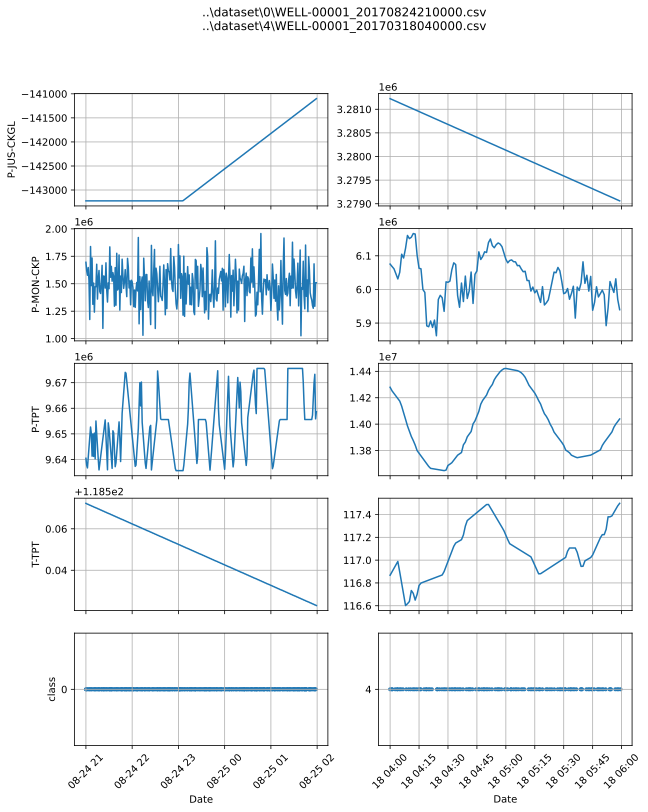

In [41]:
gen.plot([0,2])
plt.savefig('plot.jpg')

In [522]:
class driftGen:
    '''Drift Generator
       Generates a stream of features with all ones except in the interval [p1, p2] where a normal distribution
       N(mu, s) is used. The change is smoothed in w steps.
    '''
    def __init__(self, features, features_drift, mu, s, p1, p2, w):
        if isinstance(features, list):
            self.features = features
            self.n_feat = len(features)
        else:
            self.features = [features]
            self.n_feat = 1
        if isinstance(features_drift, list):
            self.features_drift = features_drift
        else:
            self.features_drift = [features_drift]
        if isinstance(mu, list):
            if self.n_feat != len(mu):
                raise NameError('n mus != n features')
            self.mu = mu
        else:
            self.mu = self.n_feat*[mu]
        if isinstance(s, list):
            if self.n_feat != len(s):
                raise NameError('n s != n features')
            self.s = s
        else:
            self.s = self.n_feat*[s]
        self.p1 = p1
        self.p2 = p2
        self.w = w
        self.rng = rng = np.random.default_rng(200560)
        return

    def iter(self, i):
        v = -4.0 * float(i - self.p1)*float(self.p2-i) / pow(float(self.w), 2)
        if v > 10:
            probability_drift = 0.0
        elif v < -10:
            probability_drift = 1.0
        else:
            probability_drift = 1.0 / (1.0 + np.exp(v))
        rec = dict()
        for j, f in enumerate(self.features):
            if f in self.features_drift:
                rec[f] = 1 + probability_drift * self.rng.normal(self.mu[j], self.s[j])
            else:
                rec[f] = 1
        return rec

### DRIFT IMPACT  

  Hacer un ranking con aquellas features que son más importantes para el modelo. Un método sencillo es hacerlo con Random Forest, hay muchos sitios en la web que muestran cómo hacerlo, si te da problemas me dices.  

  Meter drift solo en la feature más importante, y mira a ver si el modelo sigue siendo igual de afectado que antes. Si ves que no le afecta demasiado, sigue añadiendo drift a otra caracteristica, y así sucesivamente hasta ver en qué punto el modelo empieza a verse afectado.  

  Como punto opcional, puedes probar a provocar drift de la manera que te proponía, simplemente cambiando los valores de una feature por otra a partir del punto que decidas.

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [523]:
def fit_model(data_df, flist, target, model0, drB, flist_drift, dr_min, dr_max, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
       drB: 
            0 No drift
            1 drift added to flist_drift features from dr_min to dr_max
            2 shuffle features from dr_min to dr_max
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = 15

    if drB == 1:
        dr = driftGen(flist, flist_drift, 1, 2, dr_min, dr_max, 50)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        if drB == 2:
            if i >= dr_min and i <= dr_max:
                xval = list(x.values())
                np.random.shuffle(xval)
                x = {k: xval[i] for i, k in enumerate(x.keys())}
        elif drB == 1:
            d = dr.iter(i)
            x = {k: v*d[k] for k, v in x.items()}
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)
            
            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n\n', 'Drift added:', drB)
    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, ifiles, model

In [692]:
%%time

model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model = linear_model.SoftmaxRegression(l2=1)
#model =  multiclass.OneVsRestClassifier(linear_model.PAClassifier(C=10.0, mode=2))
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
flist_drift = flist[:]
dr_min = 5000
dr_max = 15000

ys, y_preds, accuracies, ifiles, model_fitted, df = fit_model(data_df, flist, 'class', model, 0, 
                                                          flist_drift, dr_min, dr_max, True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 68.71%

            Precision   Recall   F1       Support  
                                                  
     0.0      91.94%   95.68%   93.77%     26894  
     4.0      58.17%   41.75%   48.61%      3873  
                                                  
   Macro      75.05%   68.71%   71.19%            
   Micro      88.89%   88.89%   88.89%            
Weighted      87.69%   88.89%   88.09%            

                 88.89% accuracy                  
CPU times: total: 30.9 s
Wall time: 30.9 s


In [693]:
# Model without drift evaluated with data without drift
yse, y_predse, accuraciese, _, _ = fit_model(data_df, flist, 'class', model_fitted, 
                                             0, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 60.29%

            Precision   Recall   F1       Support  
                                                  
     0.0      90.05%   88.43%   89.23%     26894  
     4.0      28.58%   32.15%   30.26%      3873  
                                                  
   Macro      59.32%   60.29%   59.75%            
   Micro      81.35%   81.35%   81.35%            
Weighted      82.31%   81.35%   81.81%            

                 81.35% accuracy                  


In [583]:
model_fitted.height

10

In [584]:
from sklearn.metrics import classification_report
np.unique(y_preds, return_counts=True)
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     26894
         4.0       0.58      0.42      0.49      3873

    accuracy                           0.89     30767
   macro avg       0.75      0.69      0.71     30767
weighted avg       0.88      0.89      0.88     30767



In [585]:
# Variable Importance

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=200560)
forest.fit(df.drop('class', axis=1), df['class'])
print('mean accuracy Random Forest: ', forest.score(df.drop('class', axis=1), df['class']))
varImp = {'var': df.columns[:-1], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in df.columns[:-1].str.split('_')], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

mean accuracy Random Forest:  1.0
                 var    varImp
21   P-JUS-CKGL_rSEM  0.085096
17    T-JUS-CKP_rSEM  0.082346
19    T-JUS-CKP_rMin  0.074090
23   P-JUS-CKGL_rMin  0.059265
22   P-JUS-CKGL_rMax  0.057860
18    T-JUS-CKP_rMax  0.057178
9         T-TPT_rSEM  0.055887
13    P-MON-CKP_rSEM  0.055638
20  P-JUS-CKGL_rmean  0.055101
10        T-TPT_rMax  0.054716
16   T-JUS-CKP_rmean  0.045756
14    P-MON-CKP_rMax  0.042545
15    P-MON-CKP_rMin  0.041118
12   P-MON-CKP_rmean  0.038983
7         P-TPT_rMin  0.034989
4        P-TPT_rmean  0.033243
6         P-TPT_rMax  0.032232
11        T-TPT_rMin  0.031297
8        T-TPT_rmean  0.030323
5         P-TPT_rSEM  0.021811
3         P-PDG_rMin  0.003712
1         P-PDG_rSEM  0.002850
0        P-PDG_rmean  0.002772
2         P-PDG_rMax  0.001081
27          QGL_rMin  0.000047
26          QGL_rMax  0.000032
25          QGL_rSEM  0.000027
24         QGL_rmean  0.000008


,var,varImp
0,T-JUS-CKP,0.259369
1,P-JUS-CKGL,0.257321
2,P-MON-CKP,0.178283
3,T-TPT,0.172223
4,P-TPT,0.122275
5,P-PDG,0.010415
6,QGL,0.000114


In [602]:
# Fit model with drift
flist_drift = ['P-JUS-CKGL', 'T-JUS-CKP', 'P-MON-CKP']
ysD, y_predsD, accuraciesD, ifilesD, model_fittedD, dfD = fit_model(data_df, flist, 'class', model, 1, 
                                                               flist_drift, dr_min, dr_max, True)

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 68.66%

            Precision   Recall   F1       Support  
                                                  
     0.0      91.94%   95.39%   93.63%     26894  
     4.0      56.68%   41.93%   48.20%      3873  
                                                  
   Macro      74.31%   68.66%   70.92%            
   Micro      88.66%   88.66%   88.66%            
Weighted      87.50%   88.66%   87.91%            

                 88.66% accuracy                  


In [587]:
# model fitted without drift evaluated with drift
ysDe, y_predsDe, accuraciesDe, _, _ = fit_model(data_df, flist, 'class', model_fitted, 
                                                1, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 57.24%

            Precision   Recall   F1       Support  
                                                  
     0.0      89.26%   88.19%   88.72%     26894  
     4.0      24.27%   26.28%   25.24%      3873  
                                                  
   Macro      56.76%   57.24%   56.98%            
   Micro      80.40%   80.40%   80.40%            
Weighted      81.08%   80.40%   80.73%            

                 80.40% accuracy                  


In [603]:
# model fitted with drift evaluated with drift
ysDDe, y_predsDDe, accuraciesDDe, _, _ = fit_model(data_df, flist, 'class', model_fittedD, 
                                                1, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 61.35%

            Precision   Recall   F1       Support  
                                                  
     0.0      90.28%   89.91%   90.09%     26894  
     4.0      31.88%   32.79%   32.33%      3873  
                                                  
   Macro      61.08%   61.35%   61.21%            
   Micro      82.72%   82.72%   82.72%            
Weighted      82.93%   82.72%   82.82%            

                 82.72% accuracy                  


In [604]:
# model fitted with drift evaluated without drift
ysD0e, y_predsD0e, accuraciesD0e, _, _ = fit_model(data_df, flist, 'class', model_fittedD, 
                                                0, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 64.39%

            Precision   Recall   F1       Support  
                                                  
     0.0      91.07%   90.26%   90.66%     26894  
     4.0      36.29%   38.52%   37.37%      3873  
                                                  
   Macro      63.68%   64.39%   64.02%            
   Micro      83.75%   83.75%   83.75%            
Weighted      84.17%   83.75%   83.95%            

                 83.75% accuracy                  


In [608]:
def plot_acc(accuracies, accuraciesD, supt, subt):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(accuracies, label='Not modified')
    plt.plot(accuraciesD, label='Drift added')
    plt.legend(loc="lower right")
    plt.title(supt+'\nDrift added in the interval ['+str(dr_min)+', '+str(dr_max)+']\n'+ subt)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    plt.show()
    return

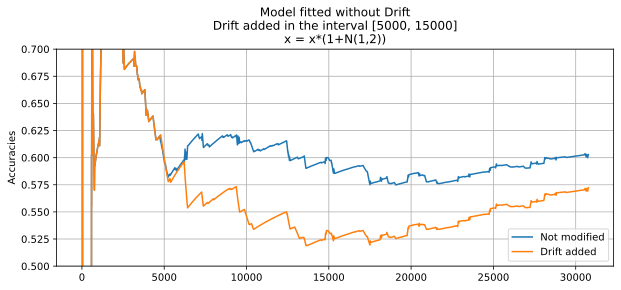

In [609]:
#plot_acc(accuracies, accuraciesD, 'Shuffle variables')
plot_acc(accuraciese, accuraciesDe, 'Model fitted without Drift', 'x = x*(1+N(1,2))')

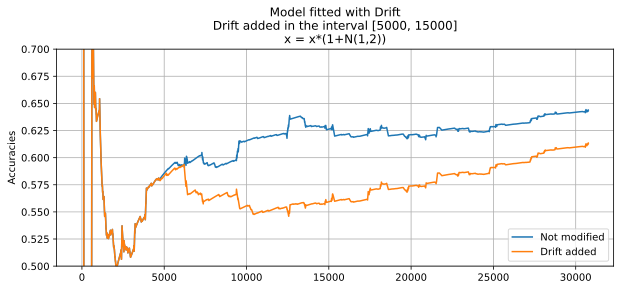

In [610]:
#plot_acc(accuracies, accuraciesD, 'Shuffle variables')
plot_acc(accuraciesD0e, accuraciesDDe, 'Model fitted with Drift', 'x = x*(1+N(1,2))')

## Drift test

In [593]:
def adwin_drift(df, ks, delta=0.02, clock=32, min_window_length=5):
    adwins = [drift.ADWIN(delta=delta, clock=clock, min_window_length=min_window_length) for k in ks]

    xds = []
    yds = []
    lastfile = -1
    driftb = False
    for i in range(len(df.index)):
        if ifiles[i] != lastfile:
            adwins = [drift.ADWIN(delta=delta, clock=clock, min_window_length=min_window_length) for k in ks]
            lastfile = ifiles[i]
        for j, k in enumerate(ks):
            _ = adwins[j].update(df[k][i])
        if np.sum([adwin.drift_detected for adwin in adwins]) > len(ks)//2:
            print(f"Change detected at index {i}, ifile: {ifiles[i]}")
            xds.append(i)
            yds.append([df[k][i] for k in ks])
            driftb = True
    if not driftb:
        print('No drift detected')
    return xds, yds

In [611]:
# Dataset without Drift

ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
#ks = ['P-JUS-CKGL_rSEM']
_ = adwin_drift(df, ks, delta=0.001, clock=32, min_window_length=5)
#_ = adwin_drift(df, ks)

No drift detected


In [612]:
# Dataset with Drift

_ = adwin_drift(dfD, ks, delta=0.001, clock=32, min_window_length=5)
#_ = adwin_drift(dfD, ks)

Change detected at index 4757, ifile: 20
Change detected at index 5478, ifile: 23
Change detected at index 13442, ifile: 55


In [622]:
def kswin_drift(df, ks, alpha=0.05, window_size=100, stat_size=30):
    kswins = [drift.KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size, 
                          seed=200560) for k in ks]

    xds = []
    yds = []
    lastfile = -1
    driftb = False
    for i in range(len(df.index)):
        if ifiles[i] != lastfile:
            kswins = [drift.KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size, 
                                  seed=200560) for k in ks]
            lastfile = ifiles[i]
        for j, k in enumerate(ks):
            _ = kswins[j].update(df[k][i])
        if np.sum([kswin.drift_detected for kswin in kswins]) > len(ks)//2:
            print(f"Change detected at index {i}, ifile: {ifiles[i]}")
            xds.append(i)
            yds.append([df[k][i] for k in ks])
            driftb = True
    if not driftb:
        print('No drift detected')
    return xds, yds

In [663]:
# Dataset without Drift

ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
#ks = ['P-JUS-CKGL_rSEM']
_ = kswin_drift(df, ks, alpha=1.E-5, window_size=100, stat_size=10)
#_ = kswin_drift(df, ks)

No drift detected


In [664]:
# Dataset with Drift

ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
#ks = ['P-JUS-CKGL_rSEM']
_ = kswin_drift(dfD, ks, alpha=1.E-5, window_size=100, stat_size=10)
#_ = kswin_drift(dfD, ks)

No drift detected


In [619]:
def phwin_drift(df, ks, min_instances=50, delta=0.005, threshold=50):
    phwins = [drift.PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold) for k in ks]

    xds = []
    yds = []
    lastfile = -1
    driftb = False
    for i in range(len(df.index)):
        if ifiles[i] != lastfile:
            phwins = [drift.PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold) for k in ks]
            lastfile = ifiles[i]
        for j, k in enumerate(ks):
            _ = phwins[j].update(df[k][i])
        if np.sum([phwin.drift_detected for phwin in phwins]) > len(ks)//2:
            print(f"Change detected at index {i}, ifile: {ifiles[i]}")
            xds.append(i)
            yds.append([df[k][i] for k in ks])
            driftb = True
    if not driftb:
        print('No drift detected')
    return xds, yds

In [620]:
# Dataset without Drift

ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
ks = ['P-JUS-CKGL_rSEM']
_ = phwin_drift(df, ks, min_instances=120, delta=0.005, threshold=35)
#_ = phwin_drift(df, ks)

No drift detected


In [621]:
# Dataset with Drift

ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
#ks = ['P-JUS-CKGL_rSEM']
_ = phwin_drift(dfD, ks, min_instances=120, delta=0.005, threshold=35)
#_ = phwin_drift(dfD, ks)

Change detected at index 5470, ifile: 23
Change detected at index 5590, ifile: 23
Change detected at index 6042, ifile: 25
Change detected at index 6162, ifile: 25
Change detected at index 7110, ifile: 30
Change detected at index 7500, ifile: 32
Change detected at index 8637, ifile: 36
Change detected at index 9208, ifile: 38
Change detected at index 9328, ifile: 38
Change detected at index 9705, ifile: 41
Change detected at index 10564, ifile: 44
Change detected at index 10684, ifile: 44
Change detected at index 11135, ifile: 46
Change detected at index 11255, ifile: 46


### ENSAMBLA LA SOLUCION:  

Partiendo de todo lo que has hecho, haz un pequeño componente que haga todo lo anterior:  

1. Algoritmo que aprende
2. Detector que le avisa de cuándo hay drift
3. El algoritmo se adapta cuando ese aviso llega
4. EL algoritmo recupera su performance despues del drift al compararlo con uno que no hace nada (como el que tienes en los plot)

In [685]:
def fit_modelD(data_df, flist, target, model0, ks, drB, flist_drift, dr_min, dr_max, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
       drB: 
            0 No drift
            1 drift added to flist_drift features from dr_min to dr_max
            2 shuffle features from dr_min to dr_max
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    phwins = [drift.PageHinkley(min_instances=120, delta=0.005, threshold=35) for k in ks]
    window_size = 15

    if drB == 1:
        dr = driftGen(flist, flist_drift, 1, 2, dr_min, dr_max, 50)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    xds = []
    drift_period = -1
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            phwins = [drift.PageHinkley(min_instances=120, delta=0.005, threshold=35) for k in ks]
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        if drB == 2:
            if i >= dr_min and i <= dr_max:
                xval = list(x.values())
                np.random.shuffle(xval)
                x = {k: xval[i] for i, k in enumerate(x.keys())}
        elif drB == 1:
            d = dr.iter(i)
            x = {k: v*d[k] for k, v in x.items()}
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()

        for jj, k in enumerate(ks):
            _ = phwins[jj].update(xd[k])
        if np.sum([phwin.drift_detected for phwin in phwins]) > len(ks)//2 and i > drift_period and not EvalB:
            print(f"\nChange detected at index {i}, ifile: {ifile}\n")
            xds.append(i)
            drift_period = i+500
        
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB and i > drift_period:
                model.learn_one(xd, y)
            
            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n\n', 'Drift added:', drB)
    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, ifiles, model

In [695]:
%%time

# Fit model with data not drifted
model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
flist_drift = flist[:]
dr_min = 5000
dr_max = 15000

ys, y_preds, accuracies, ifiles, model_fitted, df = fit_modelD(data_df, flist, 'class', model, ks, 0, 
                                                          flist_drift, dr_min, dr_max, True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 68.71%

            Precision   Recall   F1       Support  
                                                  
     0.0      91.94%   95.68%   93.77%     26894  
     4.0      58.17%   41.75%   48.61%      3873  
                                                  
   Macro      75.05%   68.71%   71.19%            
   Micro      88.89%   88.89%   88.89%            
Weighted      87.69%   88.89%   88.09%            

                 88.89% accuracy                  
CPU times: total: 33.2 s
Wall time: 33.2 s


In [698]:
%%time

# Fit model with data drifted
model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
ks = ['T-JUS-CKP_rSEM', 'P-JUS-CKGL_rSEM', 'T-JUS-CKP_rMin', 'P-JUS-CKGL_rMin', 'P-JUS-CKGL_rmean', 'T-JUS-CKP_rMax']
flist_drift = flist_drift = ['P-JUS-CKGL', 'T-JUS-CKP', 'P-MON-CKP']
dr_min = 5000
dr_max = 15000

ysD, y_predsD, accuraciesD, ifilesD, model_fittedD, dfD = fit_modelD(data_df, flist, 'class', model, ks, 1, 
                                                          flist_drift, dr_min, dr_max, True)

files learned  24 / 130
Change detected at index 5792, ifile: 23

files learned  26 / 130
Change detected at index 6392, ifile: 25

files learned  31 / 130
Change detected at index 7530, ifile: 30

files learned  33 / 130
Change detected at index 8068, ifile: 32

files learned  35 / 130
Change detected at index 8665, ifile: 34

files learned  38 / 130
Change detected at index 9441, ifile: 37

files learned  40 / 130
Change detected at index 10039, ifile: 39

files learned  45 / 130
Change detected at index 11180, ifile: 44

files learned  47 / 130
Change detected at index 11779, ifile: 46

files learned  49 / 130
Change detected at index 12372, ifile: 48

files learned  51 / 130
Change detected at index 12971, ifile: 50

files learned  58 / 130
Change detected at index 14528, ifile: 57

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 62.42%

            Precision   Recall   F1       Support  
                                                  
     0.0      90.36%   95.94%

In [696]:
# Model without drift evaluated with data without drift
yse, y_predse, accuraciese, _, _ = fit_modelD(data_df, flist, 'class', model_fitted, ks,
                                             0, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 60.29%

            Precision   Recall   F1       Support  
                                                  
     0.0      90.05%   88.43%   89.23%     26894  
     4.0      28.58%   32.15%   30.26%      3873  
                                                  
   Macro      59.32%   60.29%   59.75%            
   Micro      81.35%   81.35%   81.35%            
Weighted      82.31%   81.35%   81.81%            

                 81.35% accuracy                  


In [697]:
# model fitted without drift evaluated with drift
ysDe, y_predsDe, accuraciesDe, _, _ = fit_modelD(data_df, flist, 'class', model_fitted, ks,
                                                1, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 57.31%

            Precision   Recall   F1       Support  
                                                  
     0.0      89.27%   88.42%   88.84%     26894  
     4.0      24.58%   26.21%   25.37%      3873  
                                                  
   Macro      56.92%   57.31%   57.10%            
   Micro      80.59%   80.59%   80.59%            
Weighted      81.13%   80.59%   80.85%            

                 80.59% accuracy                  


In [699]:
# model fitted with drift evaluated with drift
ysDDe, y_predsDDe, accuraciesDDe, _, _ = fit_modelD(data_df, flist, 'class', model_fittedD, ks,
                                                1, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 1

 BalancedAccuracy: 65.40%

            Precision   Recall   F1       Support  
                                                  
     0.0      91.55%   85.82%   88.59%     26894  
     4.0      31.36%   44.98%   36.95%      3873  
                                                  
   Macro      61.45%   65.40%   62.77%            
   Micro      80.68%   80.68%   80.68%            
Weighted      83.97%   80.68%   82.09%            

                 80.68% accuracy                  


In [700]:
# model fitted with drift evaluated without drift
ysD0e, y_predsD0e, accuraciesD0e, _, _ = fit_modelD(data_df, flist, 'class', model_fittedD, ks,
                                                0, flist_drift, dr_min, dr_max, EvalB=True)

files learned  130 / 130

 Drift added: 0

 BalancedAccuracy: 66.52%

            Precision   Recall   F1       Support  
                                                  
     0.0      92.13%   81.24%   86.34%     26894  
     4.0      28.45%   51.79%   36.73%      3873  
                                                  
   Macro      60.29%   66.52%   61.53%            
   Micro      77.53%   77.53%   77.53%            
Weighted      84.11%   77.53%   80.10%            

                 77.53% accuracy                  


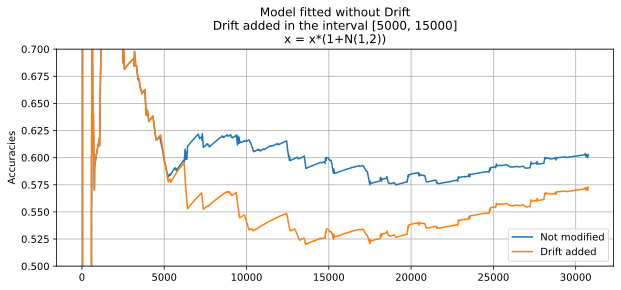

In [701]:
#plot_acc(accuracies, accuraciesD, 'Shuffle variables')
plot_acc(accuraciese, accuraciesDe, 'Model fitted without Drift', 'x = x*(1+N(1,2))')

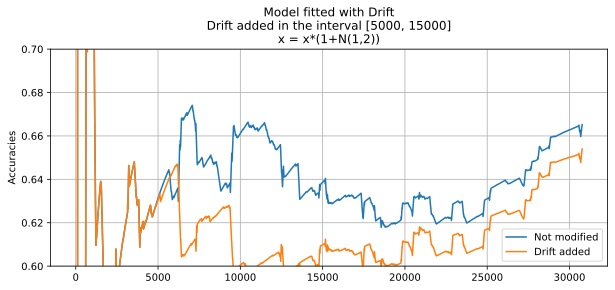

In [702]:
#plot_acc(accuracies, accuraciesD, 'Shuffle variables')
plot_acc(accuraciesD0e, accuraciesDDe, 'Model fitted with Drift', 'x = x*(1+N(1,2))')

### Outlier Detection

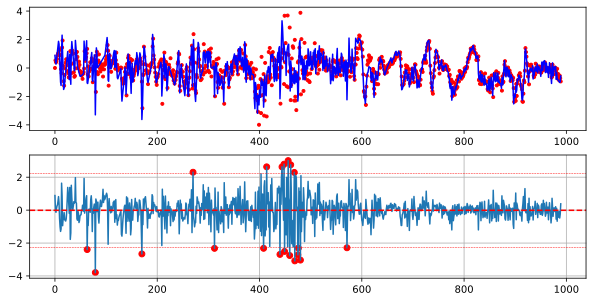

In [62]:
ODM = time_series.SNARIMAX(p=15, d=0, q=15, regressor=linear_model.LinearRegression())

flist = ['T-JUS-CKP']
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
y1 = [0]
xs = []
xfs = []
for i, (ifile, time, x, t) in enumerate(gen.iter(max_n=1000)):
    ODM.learn_one(x['T-JUS-CKP'])
    if i > 10:
        y0 = ODM.forecast(1)
        xs.append(x['T-JUS-CKP'])
        xfs.append(y1[0])
        #print(i, time, x['T-JUS-CKP'] - y1[0])
        y1 = y0

fig, axs = plt.subplots(nrows=2, figsize=(10,5))

axs[0].plot(xs, c='blue')
axs[0].scatter(x=range(len(xs)), y=xfs, c='red', marker='.')

err = [x-y for x, y in zip(xs, xfs)]
err_mean = np.mean(err)
err_std = np.std(err)
err_out = [(i, x) for i, x in enumerate(err) if abs(x-err_mean) > 3*err_std]
axs[1].plot(err)
axs[1].axhline(err_mean, color='red', linestyle='dashed')
axs[1].axhline(err_mean + 3*err_std, color='red', linestyle='dashed', lw=0.5)
axs[1].axhline(err_mean - 3*err_std, color='red', linestyle='dashed', lw=0.5)
axs[1].scatter(x=[x[0] for x in err_out], y=[x[1] for x in err_out], c='red')
axs[1].grid()

In [130]:
%%time

# Import modules.
from pysad.models import LODA, LocalOutlierProbability, xStream, HalfSpaceTrees, StandardAbsoluteDeviation
from pysad.models import KitNet, RobustRandomCutForest, ExactStorm

min_std = {'P-PDG': 1000, 'P-TPT': 1000, 'T-TPT': 0.1, 'P-MON-CKP': 1000, 'T-JUS-CKP': 0.1, 
           'P-JUS-CKGL': 1000, 'T-JUS-CKGL': 0.1, 'QGL': 10}

model = ExactStorm(window_size=120, max_radius=0.1)  # Init model

flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL']
#flist = ['T-JUS-CKP', 'P-MON-CKP']
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True, min_std=min_std)

los = []
xs = []
for i, (ifile, time, x, t) in enumerate(gen.iter(max_n=10000)):
    xs.append(x)
    lo = model.fit_score_partial(np.array(list(x.values()))) # Fit the instance to model and score the instance.
    los.append(lo)
    #print(x['T-JUS-CKP'], lo)
xs = pd.DataFrame(xs)

CPU times: total: 5.33 s
Wall time: 5.33 s


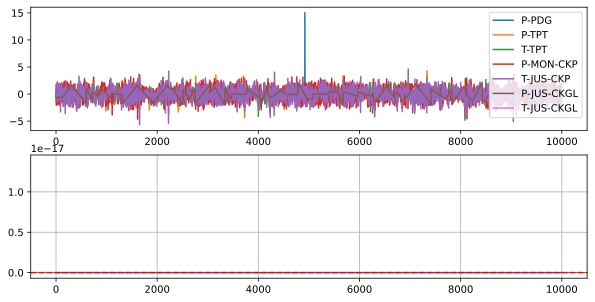

In [131]:
fig, axs = plt.subplots(nrows=2, figsize=(10,5))

xs.plot(y=flist, use_index=True, ax=axs[0])

err_mean = np.mean(los)
err_std = np.std(los)
err_out = [(i, x) for i, x in enumerate(los) if abs(x-err_mean) > 3*err_std]
axs[1].plot(los)
axs[1].axhline(err_mean, color='red', linestyle='dashed')
axs[1].axhline(err_mean + 3*err_std, color='red', linestyle='dashed', lw=0.5)
axs[1].axhline(err_mean - 3*err_std, color='red', linestyle='dashed', lw=0.5)
axs[1].scatter(x=[x[0] for x in err_out], y=[x[1] for x in err_out], c='red')
axs[1].grid()

In [81]:
import collections
from river import base

def safe_div(a, b):
    """Returns a if b is nil, else divides a by b.
    When scaling, sometimes a denominator might be nil. For instance, during standard scaling
    the denominator can be nil if a feature has no variance.
    """
    return a / b if b else 0.0


class StandardScaler_(base.MiniBatchTransformer):
    """Scales the data so that it has zero mean and unit variance.
    Under the hood, a running mean and a running variance are maintained. The scaling is slightly
    different than when scaling the data in batch because the exact means and variances are not
    known in advance. However, this doesn't have a detrimental impact on performance in the long
    run.
    This transformer supports mini-batches as well as single instances. In the mini-batch case, the
    number of columns and the ordering of the columns are allowed to change between subsequent
    calls. In other words, this transformer will keep working even if you add and/or remove
    features every time you call `learn_many` and `transform_many`.
    Parameters
    ----------
    with_std
        Whether or not each feature should be divided by its standard deviation.
    Examples
    --------
    >>> import random
    >>> from river import preprocessing
    >>> random.seed(42)
    >>> X = [{'x': random.uniform(8, 12), 'y': random.uniform(8, 12)} for _ in range(6)]
    >>> for x in X:
    ...     print(x)
    {'x': 10.557, 'y': 8.100}
    {'x': 9.100, 'y': 8.892}
    {'x': 10.945, 'y': 10.706}
    {'x': 11.568, 'y': 8.347}
    {'x': 9.687, 'y': 8.119}
    {'x': 8.874, 'y': 10.021}
    >>> scaler = preprocessing.StandardScaler()
    >>> for x in X:
    ...     print(scaler.learn_one(x).transform_one(x))
    {'x': 0.0, 'y': 0.0}
    {'x': -0.999, 'y': 0.999}
    {'x': 0.937, 'y': 1.350}
    {'x': 1.129, 'y': -0.651}
    {'x': -0.776, 'y': -0.729}
    {'x': -1.274, 'y': 0.992}
    This transformer also supports mini-batch updates. You can call `learn_many` and provide a
    `pandas.DataFrame`:
    >>> import pandas as pd
    >>> X = pd.DataFrame.from_dict(X)
    >>> scaler = preprocessing.StandardScaler()
    >>> scaler = scaler.learn_many(X[:3])
    >>> scaler = scaler.learn_many(X[3:])
    You can then call `transform_many` to scale a mini-batch of features:
    >>> scaler.transform_many(X)
        x         y
    0  0.444600 -0.933384
    1 -1.044259 -0.138809
    2  0.841106  1.679208
    3  1.477301 -0.685117
    4 -0.444084 -0.914195
    5 -1.274664  0.992296
    References
    ----------
    [^1]: [Welford's Method (and Friends)](https://www.embeddedrelated.com/showarticle/785.php)
    [^2]: [Batch updates for simple statistics](https://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html)
    """

    def __init__(self, with_std=True):
        self.with_std = with_std
        self.counts = collections.Counter()
        self.means = collections.defaultdict(float)
        self.vars = collections.defaultdict(float)

    def learn_one(self, x):

        for i, xi in x.items():
            self.counts[i] += 1
            old_mean = self.means[i]
            self.means[i] += (xi - old_mean) / self.counts[i]
            if self.with_std:
                self.vars[i] += (
                    (xi - old_mean) * (xi - self.means[i]) - self.vars[i]
                ) / self.counts[i]

        return self

    def transform_one(self, x, min_std=None):
        if self.with_std:
            if min_std is not None:
                assert(all(k in min_std.keys() for k in x.keys()))
                return {i: safe_div(xi - self.means[i], max(self.vars[i] ** 0.5, min_std[i])) for i, xi in x.items()}
            return {i: safe_div(xi - self.means[i], self.vars[i] ** 0.5) for i, xi in x.items()}
        return {i: xi - self.means[i] for i, xi in x.items()}

    def learn_many(self, X: pd.DataFrame):
        """Update with a mini-batch of features.
        Note that the update formulas for mean and variance are slightly different than in the
        single instance case, but they produce exactly the same result.
        Parameters
        ----------
        X
            A dataframe where each column is a feature.
        """

        # Operating on X.values, which is a view to the underlying numpy array, is slightly faster
        # than operating on X
        columns = X.columns
        X = X.values

        # In the rest of this method, old_* refers to the existing statistics, whilst new_* refers
        # to the statistics of the current mini-batch.

        new_means = np.nanmean(X, axis=0)
        # We could call np.var, but we already have the mean so we can be smart
        if self.with_std:
            new_vars = np.einsum("ij,ij->j", X, X) / len(X) - new_means**2
        else:
            new_vars = []
        new_counts = np.sum(~np.isnan(X), axis=0)

        for col, new_mean, new_var, new_count in itertools.zip_longest(
            columns, new_means, new_vars, new_counts
        ):

            old_mean = self.means[col]
            old_var = self.vars[col]
            old_count = self.counts[col]

            a = old_count / (old_count + new_count)
            b = new_count / (old_count + new_count)

            self.means[col] = a * old_mean + b * new_mean
            if self.with_std:
                self.vars[col] = a * old_var + b * new_var + a * b * (old_mean - new_mean) ** 2
            self.counts[col] += new_count

        return self

    def transform_many(self, X: pd.DataFrame, min_std=None):
        """Scale a mini-batch of features.
        Parameters
        ----------
        X
            A dataframe where each column is a feature. An exception will be raised if any of
            the features has not been seen during a previous call to `learn_many`.
        """

        means = np.array([self.means[c] for c in X.columns])
        Xt = X.values - means

        if self.with_std:
            if min_std is not None:
                assert(all(k in min_std.keys() for k in X.columns))
                stds = np.array([max(self.vars[c] ** 0.5, min_keys[c]) for c in X.columns])
            else:
                stds = np.array([self.vars[c] ** 0.5 for c in X.columns])
            np.divide(Xt, stds, where=stds > 0, out=Xt)

        return pd.DataFrame(Xt, index=X.index, columns=X.columns, copy=False)


In [87]:
ss0 = StandardScaler_()
ss1 = StandardScaler_()

flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
min_std = {'P-PDG': 1000, 'P-TPT': 1000, 'T-TPT': 0.1, 'P-MON-CKP': 1000, 'T-JUS-CKP': 0.1, 
           'P-JUS-CKGL': 1000, 'T-JUS-CKGL': 0.1, 'QGL': 10}
gen = CustomGen(data_df, flist, 'class', scaleb=False, out_time=True, ifileb=True)

for i, (ifile, time, x, t) in enumerate(gen.iter(max_n=10)):
    x0 = ss0.learn_one(x).transform_one(x)
    x1 = ss1.learn_one(x).transform_one(x, min_std)
    print(i, x0, x1, '\n')

0 {'P-PDG': 0.0, 'P-TPT': 0.0, 'T-TPT': 0.0, 'P-MON-CKP': 0.0, 'T-JUS-CKP': 0.0, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} {'P-PDG': 0.0, 'P-TPT': 0.0, 'T-TPT': 0.0, 'P-MON-CKP': 0.0, 'T-JUS-CKP': 0.0, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} 

1 {'P-PDG': 0.0, 'P-TPT': -1.0, 'T-TPT': -1.0, 'P-MON-CKP': 1.0, 'T-JUS-CKP': 1.0, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} {'P-PDG': 0.0, 'P-TPT': -1.0, 'T-TPT': -0.0007999999999697138, 'P-MON-CKP': 1.0, 'T-JUS-CKP': 0.1247733333333656, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} 

2 {'P-PDG': 0.0, 'P-TPT': 0.5094042543288756, 'T-TPT': -1.2349739192798987, 'P-MON-CKP': 0.33985117447281193, 'T-JUS-CKP': 1.2247462346842761, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} {'P-PDG': 0.0, 'P-TPT': 0.5094042543288756, 'T-TPT': -0.0016555555556863055, 'P-MON-CKP': 0.33985117447281193, 'T-JUS-CKP': 0.24954777777765003, 'P-JUS-CKGL': 0.0, 'T-JUS-CKGL': nan, 'QGL': 0.0} 

3 {'P-PDG': 0.0, 'P-TPT': 1.5554389396812673, 'T-